Цей датасет являє собою дані A/B-тесту для оцінки впливу рекламного креативу SmartAd на залученість користувачів.

План дій:
1. Огляд даних
2. Предобробка даних
3. Аналіз даних
4. Аналіз A/B тесту
5. Висновки

Доступні дані:
- `auction_id` - унікальний ідентифікатор показу BIO
- `experiment` - група тесту (контрольна або експериментальна)
- `date` - часові мітки
- `hour` - часові мітки
- `device_make` - модель гаджету
- `platform_os` - ідентифікатор операційної системи
- `browser` - тип браузеру
- `yes` - бінарні відгуки на BIO-анкету
- `no` - бінарні відгуки на BIO-анкету

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest

In [122]:
!ls

'AdSmartABdata - AdSmartABdata.csv'   Untitled.ipynb


In [123]:
df = pd.read_csv('AdSmartABdata - AdSmartABdata.csv')

# 1. Огляд даних

In [124]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [125]:
df.shape

(8077, 9)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [127]:
df.nunique()

auction_id     8077
experiment        2
date              8
hour             24
device_make     269
platform_os       3
browser          15
yes               2
no                2
dtype: int64

In [128]:
df.duplicated().sum()

0

In [129]:
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [130]:
df.describe(include='object')

,auction_id,experiment,date,device_make,browser
count,8077,8077,8077,8077,8077
unique,8077,2,8,269,15
top,fffbb9ff-568a-41a5-a0c3-6866592f80d8,control,2020-07-03,Generic Smartphone,Chrome Mobile
freq,1,4071,2015,4743,4554


In [131]:
control = df[df['experiment'] == 'control']
exposed = df[df['experiment'] == 'exposed'] 

control.shape, exposed.shape

((4071, 9), (4006, 9))

In [132]:
len(set(control['auction_id']) - set(exposed['auction_id']))

4071

# 2. Предобробка даних

In [133]:
df['date'] = pd.to_datetime(df['date'])

In [134]:
df['device_make'] = df['device_make'].apply(lambda x: x.lower().replace('$', ' ').replace('-', ' ').split()[0])

In [135]:
df['device_make'].nunique()

92

In [136]:
for i in ['platform_os', 'browser', 'device_make']:
    print(df[i].value_counts(), '\n')

platform_os
6    7648
5     428
7       1
Name: count, dtype: int64 

browser
Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Chrome                           3
Pinterest                        3
Opera Mobile                     3
Opera Mini                       1
Android                          1
Edge Mobile                      1
Firefox Mobile                   1
Puffin                           1
Name: count, dtype: int64 

device_make
generic               4743
samsung               2109
iphone                 433
nokia                  124
pixel                   77
                      ... 
dli                      1
x4_soul_infinity_z       1
wileyfox                 1
plk                      1
vce                      1
Name: count, Length: 92, dtype: int64 



In [137]:
df[df['platform_os'] == 7]

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2332,4c4332e4-25ce-483b-a565-76a76a802ca6,exposed,2020-07-03,13,lumia,7,Edge Mobile,0,0


In [138]:
df.drop(index=2332, inplace=True)

Смартфони Lumia це вже застаріла модель, яка давно не оновлюється. Вони можуть неправильно показувати рекламу або зовсім не показувати її. Цей запис потрібно видалити, оскільки він не несе жодної інформації.

In [139]:
df['browser'].value_counts()

browser
Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Chrome                           3
Opera Mobile                     3
Pinterest                        3
Android                          1
Opera Mini                       1
Firefox Mobile                   1
Puffin                           1
Name: count, dtype: int64

In [140]:
new_browser = {
    'Chrome Mobile WebView': 'WebView',
    'Mobile Safari UI/WKWebView': 'WebView',
    
    'Chrome Mobile iOS': 'Chrome Mobile',
    'Android': 'Chrome Mobile',
    'Chrome': 'Chrome Mobile',
    'Opera Mobile': 'Chrome Mobile',
    'Opera Mini': 'Chrome Mobile',
    'Firefox Mobile': 'Chrome Mobile',
    'Puffin': 'Chrome Mobile',
    
    'Facebook': 'App',
    'Pinterest': 'App'
}

df['browser'] = df['browser'].replace(new_browser)

In [150]:
x = df['device_make'].value_counts()
df['device_make'] = df['device_make'].replace({i: 'other' for i in  x.loc[x < 150].index})

In [151]:
df['device_make'].value_counts()

device_make
generic    4743
samsung    2109
other       791
iphone      433
Name: count, dtype: int64

# 3. Аналіз даних

In [153]:
df[df['yes'] == 1]['no'].mean(), df[df['no'] == 1]['yes'].mean()

(0.0, 0.0)

In [154]:
df[(df['yes'] == 0) & (df['no'] == 0)].shape

(6833, 9)

In [155]:
x = df.groupby('experiment')[['yes', 'no']].sum()
x['sum'] = x.sum(axis=1)
x.sum()

yes     572
no      671
sum    1243
dtype: int64

In [156]:
df['converted'] = df['yes'] + df['no']
df['converted'].sum()

1243

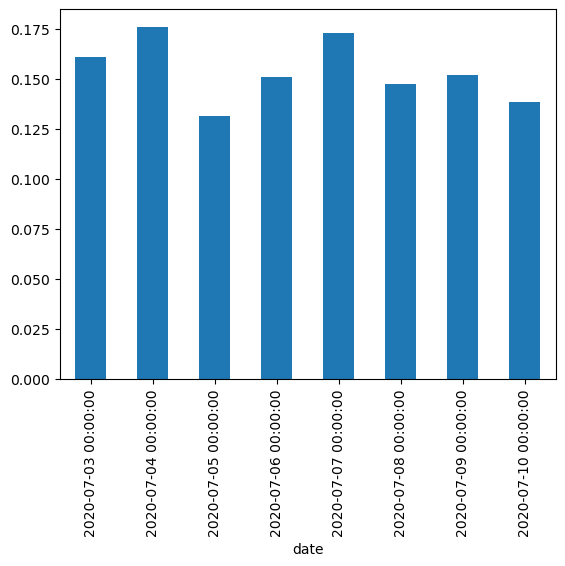

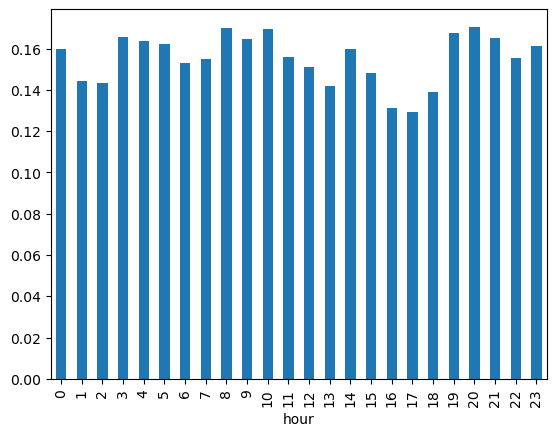

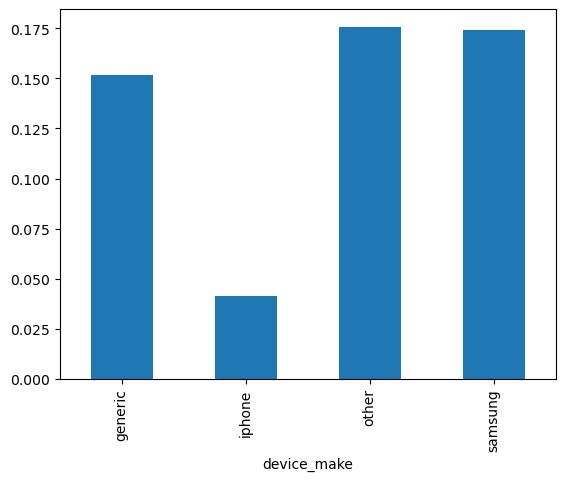

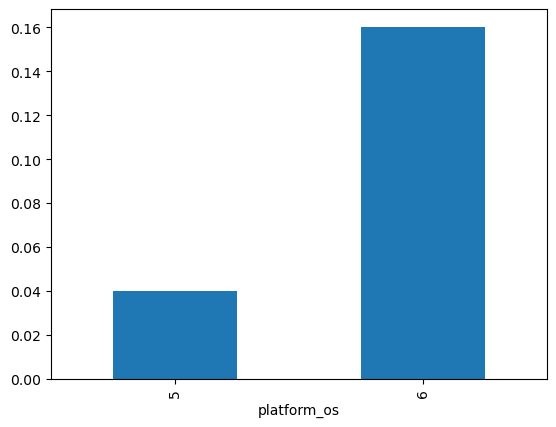

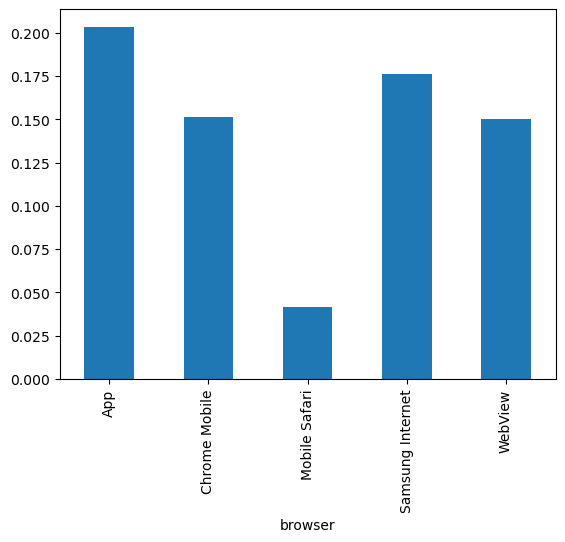

In [164]:
clmns = ['date', 'hour', 'device_make', 'platform_os', 'browser']
for i in clmns:
    df.groupby(i)['converted'].mean().plot(kind='bar')
    plt.show();

In [171]:
def bar_plot(df, grb_column, column='converted', title='', w=0.3):
    control = df[df['experiment'] == 'control'].groupby(grb_column)[column].mean()
    treatment = df[df['experiment'] == 'exposed'].groupby(grb_column)[column].mean()
    
    control_index = control.index
    tratment_index = treatment.index

    if control_index.dtype != 'int64':
        control_index = np.array([i for i, _ in enumerate(control_index)])
        tratment_index = np.array([i for i, _ in enumerate(tratment_index)])

    w = w
    
    plt.bar(control_index - w/2, height=control, width=w, label='control')
    plt.bar(tratment_index + w/2, height=treatment, width=w, label='treatment')
    
    plt.title(title)
    plt.legend()
    plt.show();

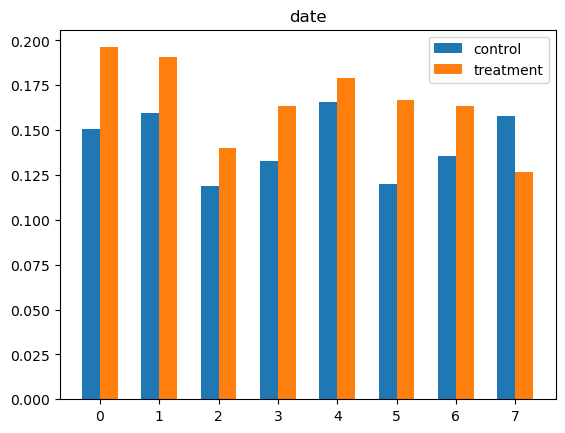

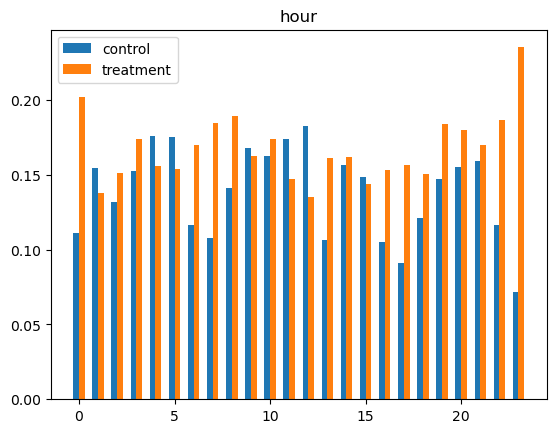

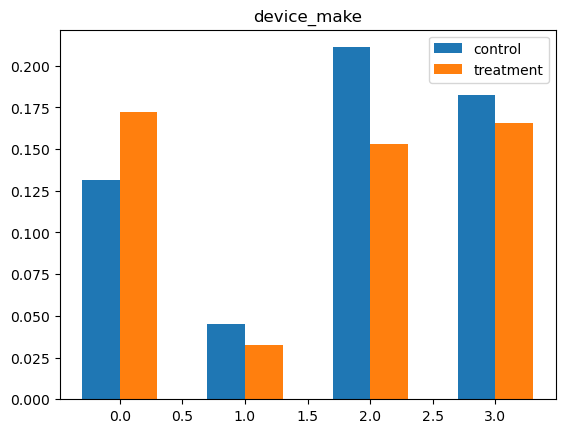

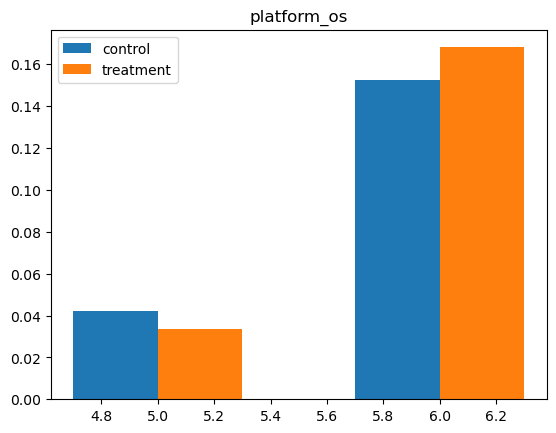

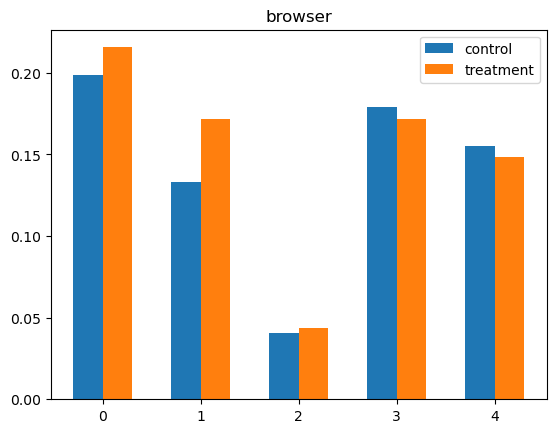

In [176]:
for i in clmns:
    bar_plot(df, i, title=i)

* На iPhone, у браузері Safari та на платформі #5 загалом конверсія дуже низька.
* **Найвища конверсія спостерігається в додатках Facebook і Pinterest.**
* Протягом усього періоду конверсія в тестовій групі була вищою.
* З 09:00 до 15:00 конверсія приблизно однакова, в інший час доби вона вища в тестовій групі.
* Через масове поширення "Generic Smartphone" вони формують основну конверсію, навіть попри те, що на пристроях iPhone, Samsung та інших вона вища в контрольній групі.
* У різних браузерах конверсія або однакова, або вища в тестовій групі.

# 4. Аналіз A/B тесту

Сформулюємо гіпотези:

* H0: Реклама SmartAd не впливає на залученість користувачів у BIO-анкету, тобто конверсія в відповідь є однаковою у контрольній та тестовій групах.
* H1: Реклама SmartAd впливає на залученість користувачів у BIO-анкету, тобто конверсія в відповідь у контрольній та тестовій групах не є рівною.

In [187]:
alpha = 0.05

a = df[df['experiment'] == 'control']['converted']
b = df[df['experiment'] == 'exposed']['converted']

z_stat, p_val = proportions_ztest([a.sum(), b.sum()], [a.count(), b.count()])

print(f'Конверсия в контрольній группі {a.mean():.3f}, в тестовій {b.mean():.3f}.')

if p_val > alpha:
    print(f'p value = {p_val:.2f}\nНульову гіпотезу не відкидаємо, конверсія в контрольній і експериментальній групах не відрізняються статистично.')
else:
    print(f'p value = {p_val:.2f}\nНульову гіпотезу відкидаємо, конверсія в контрольній і експериментальній групах відрізняються статистично.')

Конверсия в контрольній группі 0.144, в тестовій 0.164.
p value = 0.01
Нульову гіпотезу відкидаємо, конверсія в контрольній і експериментальній групах відрізняються статистично.


# 5. Висновки

Результати A/B тесту показали, що реклама SmartAd має позитивний вплив на залученість користувачів до BIO-анкети. Найвища конверсія спостерігається в додатках Facebook і Pinterest.

Особливо важливою є масова присутність Generic Smartphone, що забезпечує основну частину конверсії. На різних браузерах конверсія була або однакова, або вища в тестовій групі.

Результати статистичного тесту показали, що конверсія в контрольній та тестовій групах відрізняється (p-value = 0.01), отже, реклама SmartAd справді має позитивний вплив на залученість користувачів.

Рекомендації:
- оптимізувати рекламу для iPhone та Safari, де конверсія була дуже низькою
- збільшити рекламний бюджет на Facebook та Pinterest, де конверсія вища
- таргетувати рекламу на певні години доби для досягнення кращих результатів